In [3]:
# packages

import numpy as np
import pandas as pd
from fontTools.ttLib.tables.E_B_L_C_ import eblc_index_sub_table_3

In [4]:
SWAP_CURVE_X = np.exp(np.linspace(0, 1, 100)) - 1
#print(SWAP_CURVE_X)

In [5]:
FEE_HAIRCUT = 0.997
EXCHANGES = [
    {"input_token": 1, "input_liquidity": 2.1, "output_token": 2, "output_liquidity": 3.2, "haircut": FEE_HAIRCUT},
    {"input_token": 2, "input_liquidity": 2.2, "output_token": 3, "output_liquidity": 3.3, "haircut": FEE_HAIRCUT},
    {"input_token": 3, "input_liquidity": 2.3, "output_token": 4, "output_liquidity": 3.4, "haircut": FEE_HAIRCUT},
    {"input_token": 4, "input_liquidity": 2.4, "output_token": 1, "output_liquidity": 3.5, "haircut": FEE_HAIRCUT}, ]


In [6]:
# Define forward and backward swap calculators
from typing import Union

def forward_swap(x:Union[float, np.ndarray], haircut:float = FEE_HAIRCUT) -> Union[float, np.ndarray]:
    if isinstance(x, float):
        assert x >= 0
    elif isinstance(x, np.ndarray):
        assert np.all(x) >= 0
    assert haircut > 0
    return haircut * x /(1 + haircut * x)

def d_forward_swap(x:Union[float, np.ndarray], haircut:float = FEE_HAIRCUT) -> Union[float, np.ndarray]:
    if isinstance(x, float):
        assert x >= 0
    elif isinstance(x, np.ndarray):
        assert np.all(x) >= 0
    assert haircut > 0
    return haircut / np.square(1 + haircut*x)

def backward_swap(y:Union[float, np.ndarray], haircut:float = FEE_HAIRCUT) -> Union[float, np.ndarray]:
    if isinstance(y, float):
        assert y >= 0.0
        assert y < 1.0
    elif isinstance(y, np.ndarray):
        assert np.all(y) >= 0
        assert np.all(y < 1.0)
    assert haircut > 0
    return y /(haircut - haircut * y)



In [7]:
def generate_ITL_ratios(exchange_list:list[dict]=EXCHANGES) -> dict:
    ITL = {}
    ITL[1] = {'token': 1, 'current_in_liq': exchange_list[0]['input_liquidity']}
    for i in range(len(exchange_list)-1):
        assert exchange_list[i]['output_token'] == exchange_list[i+1]['input_token']
        token = exchange_list[i]['output_token']
        ITL[token] = {'token': token,
                      "prior_out_liq": exchange_list[i]['output_liquidity'],
                      "current_in_liq": exchange_list[i+1]['input_liquidity'],
                      "current_out_liq": exchange_list[i+1]['output_liquidity'],}
    return ITL



In [8]:
# Define swap curves
x_curve = SWAP_CURVE_X
y_curve = forward_swap(x_curve)
test_x_curve = backward_swap(y_curve)

# Check if forward_swap equals inverse of backward_swap
inverse_test = np.allclose(x_curve, test_x_curve)
print(f"Swap curves defined. \nForward and Backward are inverses: {inverse_test}")

Swap curves defined. 
Forward and Backward are inverses: True


In [9]:

def recursive_step( eta:Union[float, np.ndarray], itl:dict, x:np.array, y:np.array) -> (Union[float, np.ndarray],Union[float, np.ndarray]):
    delta_ = eta * itl['prior_out_liq']
    ratio = itl['prior_out_liq'] / itl['current_in_liq']
    dsw_ = eta * ratio                                   # Discrete swap argument: eta * (a_{j,j-1}/a_{j,j+1})
    xi_ = np.searchsorted(x, dsw_, side='right')         # x[xi_] > X
    eta_ = y[xi_]
    return delta_, eta_

In [10]:
# Experiments

exchange_list = [
    {"input_token": 1, "input_liquidity": 2.1, "output_token": 2, "output_liquidity": 3.2, "haircut": FEE_HAIRCUT},
    {"input_token": 2, "input_liquidity": 2.2, "output_token": 3, "output_liquidity": 4.3, "haircut": FEE_HAIRCUT},
    {"input_token": 3, "input_liquidity": 2.3, "output_token": 4, "output_liquidity": 3.4, "haircut": FEE_HAIRCUT},
    {"input_token": 4, "input_liquidity": 2.4, "output_token": 1, "output_liquidity": 2.5, "haircut": FEE_HAIRCUT}, ]

In [34]:


x_curve = np.linspace(0.0, 1.5, 50)
# x_curve = SWAP_CURVE_X

In [35]:
y_curve = forward_swap(x_curve)
delta_1 = x_curve * exchange_list[0]['input_liquidity']

In [36]:

eta_1 = y_curve
delta_2 = exchange_list[0]['output_liquidity'] * eta_1
itl_2 = exchange_list[0]['output_liquidity'] / exchange_list[1]['input_liquidity']
eta_2 = forward_swap(eta_1 * itl_2)
dfw_2 = d_forward_swap(eta_2)
delta_3 = exchange_list[1]['output_liquidity'] * eta_2
itl_3 = exchange_list[1]['output_liquidity'] / exchange_list[2]['input_liquidity']
eta_3 = forward_swap(eta_2 * itl_3)
dfw_3 = d_forward_swap(eta_3)
delta_4 = exchange_list[2]['output_liquidity'] * eta_3
itl_4 = exchange_list[2]['output_liquidity'] / exchange_list[3]['input_liquidity']
eta_4 = forward_swap(eta_3 * itl_4)
dfw_4 = d_forward_swap(eta_4)
delta_1_prime = exchange_list[3]['output_liquidity'] * eta_4

profit = delta_1_prime - delta_1

max_profit_indx = np.argmax(profit)

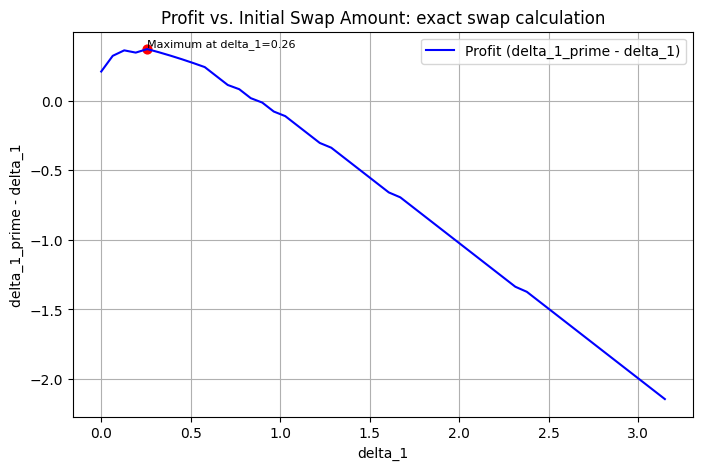

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(delta_1, profit, label="Profit (delta_1_prime - delta_1)", c='blue')
plt.scatter(delta_1[max_profit_indx], profit[max_profit_indx], s=40, c='red')
plt.text(delta_1[max_profit_indx], profit[max_profit_indx], f'Maximum at delta_1={delta_1[max_profit_indx]:4.2f}', fontsize=8, ha='left', va='bottom')
plt.xlabel("delta_1")
plt.ylabel("delta_1_prime - delta_1")
plt.title("Profit vs. Initial Swap Amount: exact swap calculation")
plt.legend()
plt.grid(True)
plt.savefig("profit-exact.pdf", format="pdf", bbox_inches="tight")
plt.show()

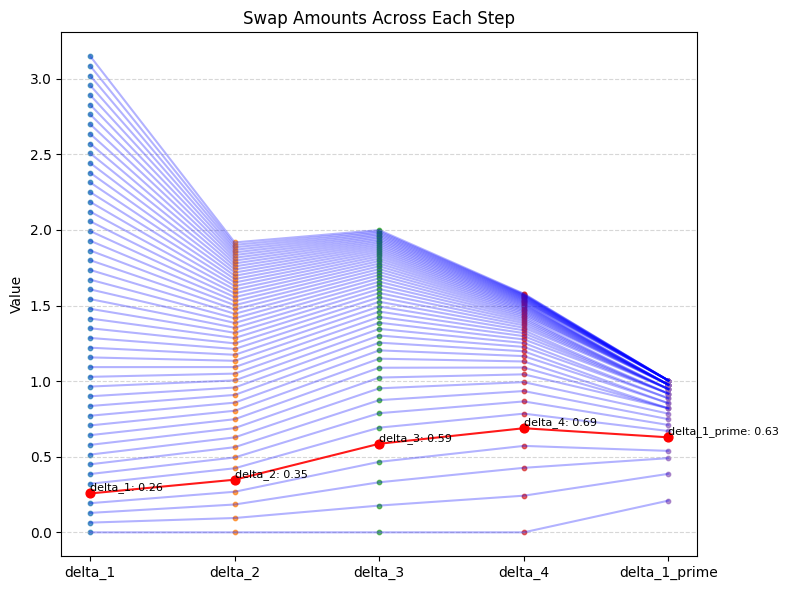

In [44]:
# Prepare the arrays and labels
swap_arrays = [delta_1, delta_2, delta_3, delta_4, delta_1_prime]
labels = ["delta_1", "delta_2", "delta_3", "delta_4", "delta_1_prime"]
#labels = ["dfw_2", "dfw_3", "dfw_4"]

plt.figure(figsize=(8, 6))
for i, arr in enumerate(swap_arrays):
    sorted_arr = np.sort(arr)
    plt.scatter([i]*len(sorted_arr), sorted_arr, s=10, alpha=0.7)
    plt.scatter(i, arr[max_profit_indx], s=40, c='red')
    if i < 4:
        plt.text(i, arr[max_profit_indx], f'delta_{i+1}: {arr[max_profit_indx]:4.2f}', fontsize=8, ha='left', va='bottom')
    else:
        plt.text(i, arr[max_profit_indx], f'delta_1_prime: {arr[max_profit_indx]:4.2f}', fontsize=8, ha='left', va='bottom')


# Draw lines connecting delta_1[i], delta_2[i], ..., delta_1_prime[i] for each i
for i in range(len(delta_1)):
    y = [arr[i] for arr in swap_arrays]
    x = list(range(len(swap_arrays)))
    if i == max_profit_indx:
        plt.plot(x, y, color='red', alpha=0.9)
    else:
        plt.plot(x, y, color='blue', alpha=0.3)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Value")
plt.title("Swap Amounts Across Each Step")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("swaps-exact.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [39]:

# Recursive compute


ITL = generate_ITL_ratios(exchange_list)

# define token variable outside loop to use below
token = 0

for itl in ITL:
    # load ITL for the current iteration
    current = ITL[itl]
    token = current['token']

    if token == 1:
        # initial step:
        #     delta_1 = x_curve * a_{1,2}
        #     eta_1   = y_curve
        current['delta'] , current['eta'] = x_curve * current['current_in_liq'] , y_curve
        delta_1 = current['delta']
    else:
        # recursion
        prior = ITL[itl-1]                           # recursion
        current['delta'] , current['eta'] = recursive_step(prior['eta'], current, x_curve, y_curve)

delta_1_prime = ITL[token]['eta'] * ITL[token]['current_out_liq']


In [40]:
profit = delta_1_prime - delta_1
max_profit_indx = np.argmax(profit)

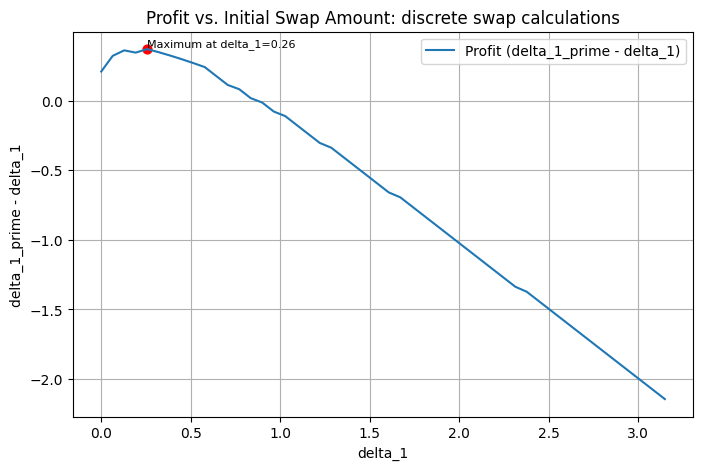

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(delta_1, profit, label="Profit (delta_1_prime - delta_1)")
plt.scatter(delta_1[max_profit_indx], profit[max_profit_indx], s=40, c='red')
plt.text(delta_1[max_profit_indx], profit[max_profit_indx], f'Maximum at delta_1={delta_1[max_profit_indx]:4.2f}', fontsize=8, ha='left', va='bottom')
plt.xlabel("delta_1")
plt.ylabel("delta_1_prime - delta_1")
plt.title("Profit vs. Initial Swap Amount: discrete swap calculations")
plt.legend()
plt.grid(True)
plt.savefig("profit-discrete.pdf", format="pdf", bbox_inches="tight")
plt.show()

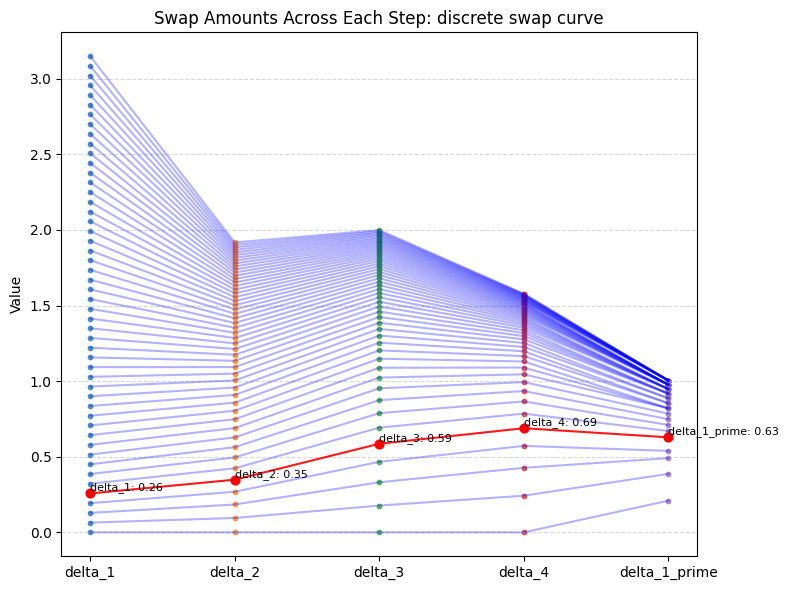

In [46]:
# Prepare the arrays and labels
swap_arrays = [delta_1, delta_2, delta_3, delta_4, delta_1_prime]
labels = ["delta_1", "delta_2", "delta_3", "delta_4", "delta_1_prime"]
#labels = ["dfw_2", "dfw_3", "dfw_4"]

plt.figure(figsize=(8, 6))
for i, arr in enumerate(swap_arrays):
    sorted_arr = np.sort(arr)
    plt.scatter([i]*len(sorted_arr), sorted_arr, s=10, alpha=0.7)
    plt.scatter(i, arr[max_profit_indx], s=40, c='red')
    if i < 4:
        plt.text(i, arr[max_profit_indx], f'delta_{i+1}: {arr[max_profit_indx]:4.2f}', fontsize=8, ha='left', va='bottom')
    else:
        plt.text(i, arr[max_profit_indx], f'delta_1_prime: {arr[max_profit_indx]:4.2f}', fontsize=8, ha='left', va='bottom')


# Draw lines connecting delta_1[i], delta_2[i], ..., delta_1_prime[i] for each i
for i in range(len(delta_1)):
    y = [arr[i] for arr in swap_arrays]
    x = list(range(len(swap_arrays)))
    if i == max_profit_indx:
        plt.plot(x, y, color='red', alpha=0.9)
    else:
        plt.plot(x, y, color='blue', alpha=0.3)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Value")
plt.title("Swap Amounts Across Each Step: discrete swap curve")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("swaps-discrete.pdf", format="pdf", bbox_inches="tight")
plt.show()